In [1]:
!git clone https://github.com/palatos/squaregrid
!pip install git+https://github.com/palatos/lime@ColorExperiments

Cloning into 'squaregrid'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 21 (delta 5), reused 17 (delta 3), pack-reused 0
Unpacking objects: 100% (21/21), done.
  Cloning https://github.com/palatos/lime (to revision ColorExperiments) to /tmp/pip-req-build-mf5ayogt
  Running command git clone -q https://github.com/palatos/lime /tmp/pip-req-build-mf5ayogt
  Running command git checkout -b ColorExperiments --track origin/ColorExperiments
  Switched to a new branch 'ColorExperiments'
  Branch 'ColorExperiments' set up to track remote branch 'ColorExperiments' from 'origin'.
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=560604 sha256=409df6c4957b4bd2d6624327ac7113c3dab9b9a903bd0448ea55a61562d214dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-gg6jivcv/wheels/20/56/54/5f14bffd9370dbc9a3270eb2ccc031aa66154f1abc220f60dd
  Created wheel for pyDOE2: filename=pyDOE2

In [2]:
import tensorflow as tf
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

Let's start with a common image in XAI papers.
We will classify this with VGG19, pretrained on Imagenet, and then generate
explanations for the classification.

(-0.5, 223.5, 223.5, -0.5)

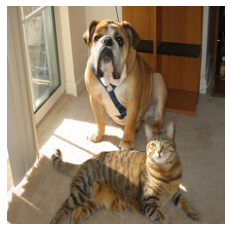

In [3]:
image = Image.open('/content/squaregrid/examples/catdog.png')
image = np.array(image.resize((224,224)))


plt.figure(facecolor='white')
plt.imshow(image)
plt.axis('off')

Let's define our classifier model for this example. You can use your own custom models too.

In this case the model receives the raw image (no color preprocessing or 
normalization), resized to (224,224,3). 

The color preprocessing actually occurs within the model, which is great for
this purpose and works well for many other XAI libraries too. Tensorflow 2.0 has been adding more preprocessing layer options that make this easier to accomplish. It also makes models easier to share. You can also add your own preprocessing functions to the model architecture. (See: https://www.tensorflow.org/guide/keras/preprocessing_layers)

Importantly, support for custom preprocessing functions outside of the model is 
planned for this repo, but not implemented yet. 

However if you must use a custom external preprocessing function, don't worry. For now you can write a Class that includes your model and the necessary preprocessing functions and pass that model to the explainer instead.

Future steps for this repo include adding an example for such cases, as well better support for custom preprocessing functions outside of the model.

In [4]:
base_model = tf.keras.applications.VGG19(weights='imagenet', include_top = True)
#We freeeze the model weights for classification. 
#This is not actually necessary, but also doesn't have negative effects.
base_model.trainable = False 

input_shape = (224, 224, 3)
inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.applications.vgg19.preprocess_input(inputs) #preprocessing layer.

#Some layers (augmentation layers, batch norm, etc) behave differently during training and inference. 
#To avoid issues with this while using eager execution, we set 'training = False' when calling this model.
out = base_model(x, training = False) #VGG19 pretrained on Imagenet.
model = tf.keras.Model(inputs, out)

574717952/574710816 [==============================] - 11s 0us/step


We use the keras API to get the class names for the top predictions.

It's very straight forward to adapt this for other models in tf.keras.applications.

In [5]:
image_prepared = np.expand_dims(image,0)
y_pred = model.predict(image_prepared)
decoded = tf.keras.applications.vgg19.decode_predictions(y_pred)
print(decoded)

40960/35363 [==================================] - 0s 0us/step
[[('n02108422', 'bull_mastiff', 0.38286775), ('n02108089', 'boxer', 0.22965571), ('n02129604', 'tiger', 0.19323185), ('n02123159', 'tiger_cat', 0.061871562), ('n02110958', 'pug', 0.024822904)]]


To generate the explanation we just need to import the SquareGrid class, instantiate it and pass the image and model to the explaining function.

In [6]:
from squaregrid.explain_image import SquareGrid

explainer = SquareGrid()
heatmaps = explainer.explain(image,model,verbose=1,top_labels=1000)

Generating explanations...
Batch size is:  200
Number of samples is:  1000
Generating explanation for grid with squares sized  8
Generating explanation for grid with squares sized  16
Generating explanation for grid with squares sized  32
Generating explanation for grid with squares sized  64
Generating heatmaps for top 1000 classes


100%|██████████| 1000/1000 [00:46<00:00, 21.59it/s]


Now that we generated the heatmaps, we can access the ones corresponding to the classes we are interested in. For this case we have classes 243 (bull mastiff) and 281 (tabby cat) within the 1000 Imagenet classes.

(-0.5, 223.5, 223.5, -0.5)

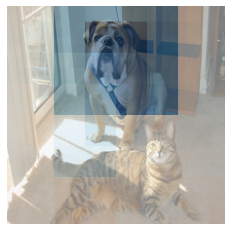

In [7]:
class_idx = 243 #bull mastiff class
plt.figure(facecolor='white')
plt.imshow(heatmaps[class_idx],cmap='RdBu',vmin=-heatmaps[class_idx].max(),vmax=heatmaps[class_idx].max())
plt.imshow(image,alpha=0.5)
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

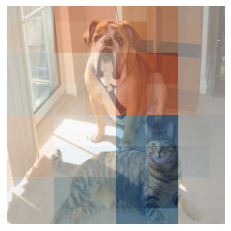

In [8]:
class_idx = 281 #tabby cat
plt.figure(facecolor='white')
plt.imshow(heatmaps[class_idx],cmap='RdBu',vmin=-heatmaps[class_idx].max(),vmax=heatmaps[class_idx].max())
plt.imshow(image,alpha=0.5)
plt.axis('off')

Let's run the same steps again for a couple other images.
For the next one we'll generate explanations only for the top predicted class.
Since this example involves 1000 classes, doing this speeds up the process of appending the final heatmaps and generating the final explanations.

To do this we can just leave the parameter top_labels = 1, which is its default value.

Let's also get LIME to display a progress_bar.

In [11]:
image = Image.open('/content/squaregrid/examples/flute.jpg')
image = np.array(image.resize((224,224)))
image_prepared = np.expand_dims(image,0)
y_pred = model.predict(image_prepared)
decoded = tf.keras.applications.vgg19.decode_predictions(y_pred)
print(decoded)

explainer = SquareGrid()
heatmaps = explainer.explain(image,model,verbose=1,progress_bar=1)

[[('n03372029', 'flute', 0.99044096), ('n03838899', 'oboe', 0.008851008), ('n03494278', 'harmonica', 0.00036922024), ('n02804610', 'bassoon', 0.00011677682), ('n03840681', 'ocarina', 4.0960826e-05)]]
Generating explanations...
Batch size is:  200
Number of samples is:  1000
Generating explanation for grid with squares sized  8



Generating explanation for grid with squares sized  16



Generating explanation for grid with squares sized  32



Generating explanation for grid with squares sized  64



Generating heatmaps for top 1 classes


100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


(-0.5, 223.5, 223.5, -0.5)

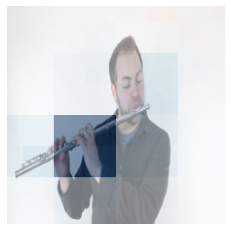

In [12]:
class_idx = 558 #flute, transverse flute
plt.figure(facecolor='white')
plt.imshow(heatmaps[class_idx],cmap='RdBu',vmin=-heatmaps[class_idx].max(),vmax=heatmaps[class_idx].max())
plt.imshow(image,alpha=0.5)
plt.axis('off')

One last one. For this one let's use a blur perturbation instead of the default one.

In [16]:
image = Image.open('/content/squaregrid/examples/shaker.jpg')
image = np.array(image.resize((224,224)))
image_prepared = np.expand_dims(image,0)
y_pred = model.predict(image_prepared)
decoded = tf.keras.applications.vgg19.decode_predictions(y_pred)
print(decoded)

explainer = SquareGrid()
heatmaps = explainer.explain(image,model,hide_color = 'blur')

[[('n04131690', 'saltshaker', 0.99848986), ('n03916031', 'perfume', 0.00060372346), ('n04591713', 'wine_bottle', 0.00021616407), ('n03983396', 'pop_bottle', 0.0002099172), ('n03062245', 'cocktail_shaker', 0.00014001089)]]


(-0.5, 223.5, 223.5, -0.5)

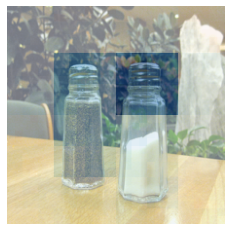

In [17]:
class_idx = 773 #saltshaker
plt.figure(facecolor='white')
plt.imshow(heatmaps[class_idx],cmap='RdBu',vmin=-heatmaps[class_idx].max(),vmax=heatmaps[class_idx].max())
plt.imshow(image,alpha=0.5)
plt.axis('off')